In [1]:
import dataclasses
import functools

import jax
from jax import numpy as jnp
import numpy as np

from flax import linen
from flax import struct
import optax
from tensorflow_probability.substrates import jax as tfp

tfb = tfp.bijectors
tfd = tfp.distributions

from brax import envs as brax_envs
from matplotlib import pylab as plt

import daves_rl_lib
from daves_rl_lib import drivers
from daves_rl_lib import networks
from daves_rl_lib.algorithms import advantage_actor_critic
from daves_rl_lib.environments import brax_environment
from daves_rl_lib.internal import util

In [2]:
batch_size = 256
discount_factor = 0.999
entropy_regularization = 1.0
steps_per_update = 20
seed = jax.random.PRNGKey(0)

In [3]:
brax_env = brax_envs.create('inverted_pendulum', episode_length=500)

# Wrap environment to terminate if the cart goes out of bounds (like OpenAI
# gym's cartpole).
original_step = brax_env.step
def step_with_pos_check(state, action, bound=4.):
    new_state = original_step(state, action)
    return dataclasses.replace(new_state,
                               done=jnp.logical_or(
                                   new_state.done,
                                   jnp.abs(new_state.obs[..., 0]) > bound))
brax_env.step = step_with_pos_check

# Work around tracer conversion errors (potential brax bug).
brax_env.reset = jax.jit(brax_env.reset)
brax_env.step = jax.jit(brax_env.step)

env = brax_environment.BRAXEnvironment(
    brax_env,
    discount_factor=discount_factor)

In [4]:
# Categorical policy produces output vectors [-1.] or [1.].
def categorical_vector_from_logits(logits):
    cat = tfp.distributions.Categorical(logits=logits, dtype=logits.dtype)
    dist = tfp.bijectors.Chain([
        tfp.bijectors.Reshape(event_shape_out=[1], event_shape_in=[]),
        tfp.bijectors.Shift(-1.),
        tfp.bijectors.Scale(2.)])(cat)
    dist.entropy = cat.entropy
    return dist

agent = advantage_actor_critic.A2CAgent(
    policy_net = networks.make_model(
                [24, 24, 2],
                obs_size=env.observation_size,
                activate_final=categorical_vector_from_logits),
    value_net = networks.make_model([24, 24, 1], obs_size=env.observation_size),
    policy_optimizer = optax.adam(1e-2),
    value_optimizer = optax.adam(3e-2),
    steps_per_update=steps_per_update,
    entropy_regularization=entropy_regularization,
    discount_factor=discount_factor)

In [5]:
weights = agent.init_weights(
    batch_size=batch_size,
    seed=seed,
    dummy_observation=env.reset(seed=seed).observation,
    dummy_action=env.action_space.dummy_action())

In [6]:
states = env.reset(seed=seed, batch_size=batch_size)

initial_observations = states.observation
dangerous_states = initial_observations + jnp.array([3.9, 0., 0., 0.])

initial_values = agent.value_net.apply(weights.agent_weights.value_weights, initial_observations)
dangerous_state_values = agent.value_net.apply(weights.agent_weights.value_weights, dangerous_states)

print("Prior to training:")
print("Values of initial states:", util.format_summary(initial_values))
print("Values of 'dangerous' states:", util.format_summary(dangerous_state_values))

Prior to training:
Values of initial states: SummaryStats(mean='-3.036068e-06', std='0.0006861618', median='-3.1457013e-05', min='-0.001162981', max='0.0011566859')
Values of 'dangerous' states: SummaryStats(mean='-0.114911996', std='0.0008444144', median='-0.11491507', min='-0.116825186', max='-0.113019876')


In [7]:

step_fn = jax.jit(drivers.jax_driver(env, agent))

In [8]:
compute_policy_entropy = jax.jit(lambda w, obs: agent.policy_net.apply(w.agent_weights.policy_weights, obs).entropy())

num_steps = []
policy_entropies = []
for _ in range(500 * 20):
    states, weights, seed = step_fn(states, weights, seed)
    num_steps.append(states.num_steps)
    policy_entropies.append(
        jnp.mean(compute_policy_entropy(weights, states.observation)))

In [9]:
policy_entropies = jnp.array(policy_entropies)
num_steps = jnp.array(num_steps)

Text(0.5, 1.0, 'Mean policy entropy')

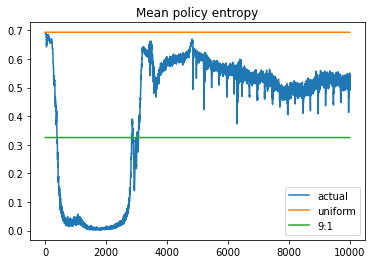

In [10]:
plt.plot(policy_entropies, label='actual')
plt.plot(jnp.ones(policy_entropies.shape[:1]) * jnp.log(2), label='uniform')
plt.plot(jnp.ones(policy_entropies.shape[:1]) * -(0.9 * jnp.log(0.9) + 0.1 * jnp.log(0.1)), label='9:1')
plt.legend()
plt.title('Mean policy entropy')

In [11]:
initial_values = agent.value_net.apply(weights.agent_weights.value_weights, initial_observations)
dangerous_state_values = agent.value_net.apply(weights.agent_weights.value_weights, dangerous_states)

print("After training:")
print("Values of initial states:", util.format_summary(initial_values))
print("Values of 'dangerous' states:", util.format_summary(dangerous_state_values))

After training:
Values of initial states: SummaryStats(mean='295.68857', std='0.36999175', median='295.6867', min='295.01605', max='296.37085')
Values of 'dangerous' states: SummaryStats(mean='309.35974', std='0.058140747', median='309.3603', min='309.22836', max='309.49268')


<Figure size 432x288 with 0 Axes>

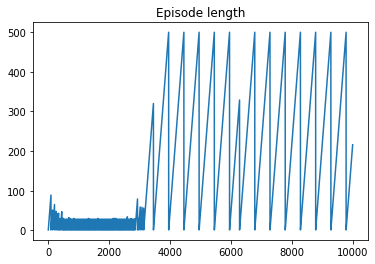

<Figure size 432x288 with 0 Axes>

In [12]:
render_batch_idx = 0

plt.plot(num_steps[:, render_batch_idx])
plt.title('Episode length')
plt.figure()


In [39]:
qps = []
for _ in range(500):
    states, weights, seed = step_fn(states, weights, seed)
    qps.append(jax.tree_util.tree_map(lambda x: x[render_batch_idx], states.unobserved))

In [41]:
from IPython import display
from brax.io import html as brax_html
from brax.io import image as brax_image

d = None
if False:  # Renders slow down VSCode so only do it if explicitly requested.
    d = display.HTML(
        brax_html.render(env._brax_env.sys, qps))
d